In [2]:
from os.path import join
import time

import einops
import numpy as np
from scipy import signal
import torch

from datasets.dreamer import DREAMERDataset
from datasets.deap import DEAPDataset
import matplotlib.pyplot as plt

# Data

In [3]:
dreamer = DREAMERDataset(path=join("..", "..", "datasets", "eeg_emotion_recognition", "dreamer"),
                         split_in_windows=True,
                         window_size=1, drop_last=True,
                         discretize_labels=True, normalize_eegs=True,
                         validation="k_fold", k_folds=10,
                         labels_to_use=["valence", "arousal", "dominance"],
                         batch_size=128)

In [4]:
deap = DEAPDataset(path=join("..", "..", "datasets", "eeg_emotion_recognition", "deap"),
                         split_in_windows=True,
                         window_size=1, drop_last=True,
                         discretize_labels=True, normalize_eegs=True,
                         validation="k_fold", k_folds=10,
                         labels_to_use=["valence", "arousal", "dominance"],
                         batch_size=128)

In [5]:
print(len(deap), len(dreamer))

76800 85744


In [8]:
print(dreamer.eegs_data.min(), dreamer.eegs_data.max())
print(deap.eegs_data.min(), deap.eegs_data.max())

tensor(-8.1110e-05) tensor(0.0001)
tensor(-4.2283e-05) tensor(3.5265e-05)


# Decompositions

## Wavelets

In [6]:
def wavelet_decompose(x, widths):
    assert any([isinstance(widths, t) for t in {np.ndarray, torch.Tensor, list}])
    assert all([width > 0 for width in widths])
    x_decomposed = torch.stack([torch.as_tensor(signal.cwt(x[:, i_channel], signal.ricker, widths))
                                for i_channel in range(x.shape[-1])], dim=-1)  # (w, s, e)
    return x_decomposed


s = wavelet_decompose(x=sample_eeg, widths=[1, 2, 4, 8, 16, 32])
print(s.shape)

NameError: name 'sample_eeg' is not defined

In [ ]:
for i in s:
    plt.plot(i)
    plt.show()

## Spectrogram

In [ ]:
import librosa


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(specgram, origin="lower", aspect="auto")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def get_mel_spectrogram(x, sampling_rate: Union[int, float]):
    transform = transforms.MelSpectrogram(sample_rate=128, f_min=3, f_max=50, n_fft=50, n_mels=8, center=True,
                                          win_length=8)
    mel_spectrogram = transform(einops.rearrange(x, "s c -> c s"))
    return mel_spectrogram

In [ ]:
from torch import nn
from torchaudio import transforms

print(sample_eeg.shape)
st = time.time()
s = get_mel_spectrogram(x=sample_eeg)
print(s.shape)
plot_spectrogram(s[0])
# plot_spectrogram(mel_specgram[0], title="MelSpectrogram - torchaudio", ylabel="mel freq")
print(time.time() - st)

# FNet embeddings

torch.Size([128, 1024, 512])


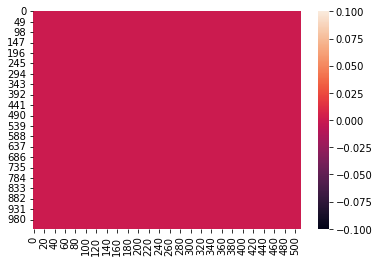

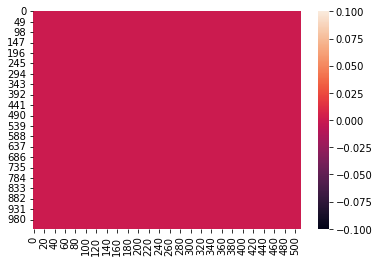

In [58]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import functorch

embeddings = torch.zeros(128, 1024, 512)
# p = torch.zeros_like(embeddings)

# f = torch.fft.fftn(embeddings[0].real)
# plt.plot(f.numpy())
# plt.show()

f = functorch.vmap(torch.fft.fftn)(embeddings).real
print(f.shape)

sns.heatmap(f[0])
plt.show()

sns.heatmap(f[-1])
plt.show()

# plt.plot(torch.fft.fft(torch.rand(12)).real)
# plt.show()

<AxesSubplot:>

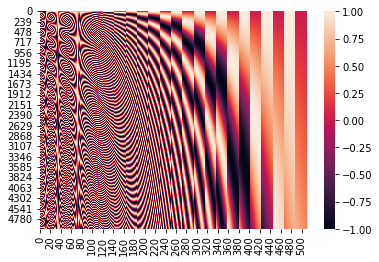

In [66]:
import math

def positionalencoding1d(d_model = 512, length = 5000):
    if d_model % 2 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with "
                         "odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(length, d_model)
    position = torch.arange(0, length).unsqueeze(1)
    div_term = torch.exp((torch.arange(0, d_model, 2, dtype=torch.float) *
                         -(math.log(10000.0) / d_model)))
    pe[:, 0::2] = torch.sin(position.float() * div_term)
    pe[:, 1::2] = torch.cos(position.float() * div_term)

    return pe

pe = positionalencoding1d()
pe.shape
sns.heatmap(pe)